In [1]:
# Pandas for managing datasets
import pandas as pd
import numpy as np
from statistics import mean
from random import choice
# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline
# Seaborn for plotting and styling
import seaborn as sns
import os
from tools.data_extraction import DataExtractor
from tools.trajectory_generator import TrajectoryGenerator
from tools.utils import standardize_data, print_genetic_param, print_settings, set_movements, angle_diff, get_distance

In [2]:
tr_gen_options = {"samples": 25,
                  "freq": 5,
                  "reset_data": True,
                 "init_speed":20}
dt_gen_options = {"n_test": 25}

train_test_options = {"split": 25}

df_csv_options = {"ts_class": "Bearing"}


first_movement = ['creeping_line_left']
second_movement = ['random']
movements = {'first_movement': first_movement,'second_movement': second_movement}
set_movements(movements)

labels = ["TIMESTAMP","LAT","LON","HEADING"]
# Create files if not created
# tr_gen = TrajectoryGenerator(**tr_gen_options)
# tr_gen.data_generation(**dt_gen_options)
real_data =  pd.read_csv("/home/kapadais/Desktop/HUA Thesis/ptixiaki hua/data/route.csv")
real_data = real_data [labels]
#real_data = real_data [["TIMESTAMP","LAT","LON"]][:750]
real_data.sort_values('TIMESTAMP',inplace=True)
real_data=real_data.reset_index(drop=True)

In [3]:
def scalling_down_simple(data,n_sample):
    data_size = len(data)
    labels = data.columns
    sampling_offset = int(data_size/n_sample)
    count = 0 
    new_data = []
    while count< data_size:
        new_data.append(data.iloc[count])
        count = count + sampling_offset
    
    return pd.DataFrame(new_data,columns=labels)

In [25]:
def check_sampling(x,sampling,data_index):
    i = 1
    sampling_acc = True
    down_limit = (x[1]-sampling)
    up_limit = (x[1]+sampling)
    while i<=sampling:
        if 0 <=down_limit and up_limit < len(data_index):
            if (data_index[x[1]-i] == True) or (data_index[x[1]+i] == True):
                sampling_acc = False
                break
        i = i + 1      
    return sampling_acc


def dist_and_bearing_diff(data):
    all_distances = []
    bearing_diff = []
    data_size=len(data)
    i = 0
    while i<data_size:
        if i + 1 >=data_size:
            break
        bearing_1, bearing_2 = data["HEADING"].iloc[i], data["HEADING"].iloc[i+1] 
        bearing_diff.append([abs(bearing_2 - bearing_1),i])
        lat_1, lon_1, lat_2, lon_2 = data["LAT"].iloc[i], data["LON"].iloc[i], data["LAT"].iloc[i+1], data["LON"].iloc[i+1]
        all_distances.append(get_distance(lat_1,lon_1,lat_2,lon_2))
        i = i +1
    return bearing_diff, all_distances 


def fitting_indexes(arr,new_size):
    i = 0
    r_arr = []
    while i <len(arr):
        if i+1 >=len(arr):
            break
        r_arr.append(arr[i+1]-arr[i])
        i = i + 1
        
    mean_space = mean(r_arr)
    i = 0 
    while i<len(arr)<new_size:
        if i+1 >=len(arr):
            break
        diff = arr[i+1]-arr[i]
        if mean_space < diff:
            step = int(diff/2)
            new_index = arr[i] + step
            arr.insert(i+1,new_index)
            i = i + 1
        i = i + 1
    return arr

def scalling_down_windowed(data,n_sample,turn_sensitivity=35):
    if len(data) <= n_sample :
        return data
    size_correction = int(len(data) / n_sample) * n_sample
    data=data[:size_correction]
    data_size=len(data)
    data_index = [False for i in range(data_size)]
    sampling = int((int(data_size/n_sample) * 0.25))
    labels = data.columns
    
    temp_idx = [] 
    final_data = pd.DataFrame(data,columns=labels)
    final_data.reset_index(drop=True)
    
    #find the number of bearing differance above the turn sensitivity
    bearing_diff , all_distances = dist_and_bearing_diff(final_data)
    mean_dist = mean(all_distances)
    for idx, x in enumerate(bearing_diff):
        sampling_acc = check_sampling(x,sampling,data_index)
        if (x[0] > turn_sensitivity) and (all_distances[idx] > mean_dist/2) and sampling_acc:
            data_index[x[1]] = True
            temp_idx.append(x[1])
    for x in temp_idx:
        print(all_distances[x],x)
    while n_sample > len(temp_idx):
        final_index=fitting_indexes(temp_idx,n_sample)

    for x in temp_idx:
        data_index[x]=True
    
    return final_data[data_index]

In [26]:
# data = scalling_down_windowed(real_data,train_test_options["split"])
# data.reset_index(drop=True)
# print(len(data))
# print(data)

556.434425188587 25
573.8466638494059 76
395.65731136517235 100
555.2552617401818 172
663.9057829811968 181
569.7214909606575 256
713.0286707827536 271
537.8052998285269 340
343.8547327680563 354
541.012202321078 430
500.90400047547024 446
416.133859446234 493
575.941219513654 515
373.97087002170724 525
size of data 25
               TIMESTAMP       LAT       LON  HEADING
25   2015-07-06 18:01:05  36.96515  18.76294       23
50   2015-07-06 19:04:06  36.97758  18.57400      270
76   2015-07-06 20:04:27  36.97751  18.38087      267
100  2015-07-06 21:02:36  36.92679  18.24255      230
118  2015-07-06 21:47:17  36.91771  18.34644       91
136  2015-07-06 22:36:15  36.91739  18.46878       92
154  2015-07-06 23:21:34  36.91325  18.58050       92
172  2015-07-07 00:28:39  36.91289  18.74479       88
181  2015-07-07 00:53:35  36.86882  18.75483      180
199  2015-07-07 01:38:34  36.85939  18.66087      270
218  2015-07-07 02:20:26  36.85836  18.56497      272
237  2015-07-07 03:08:35  36.85

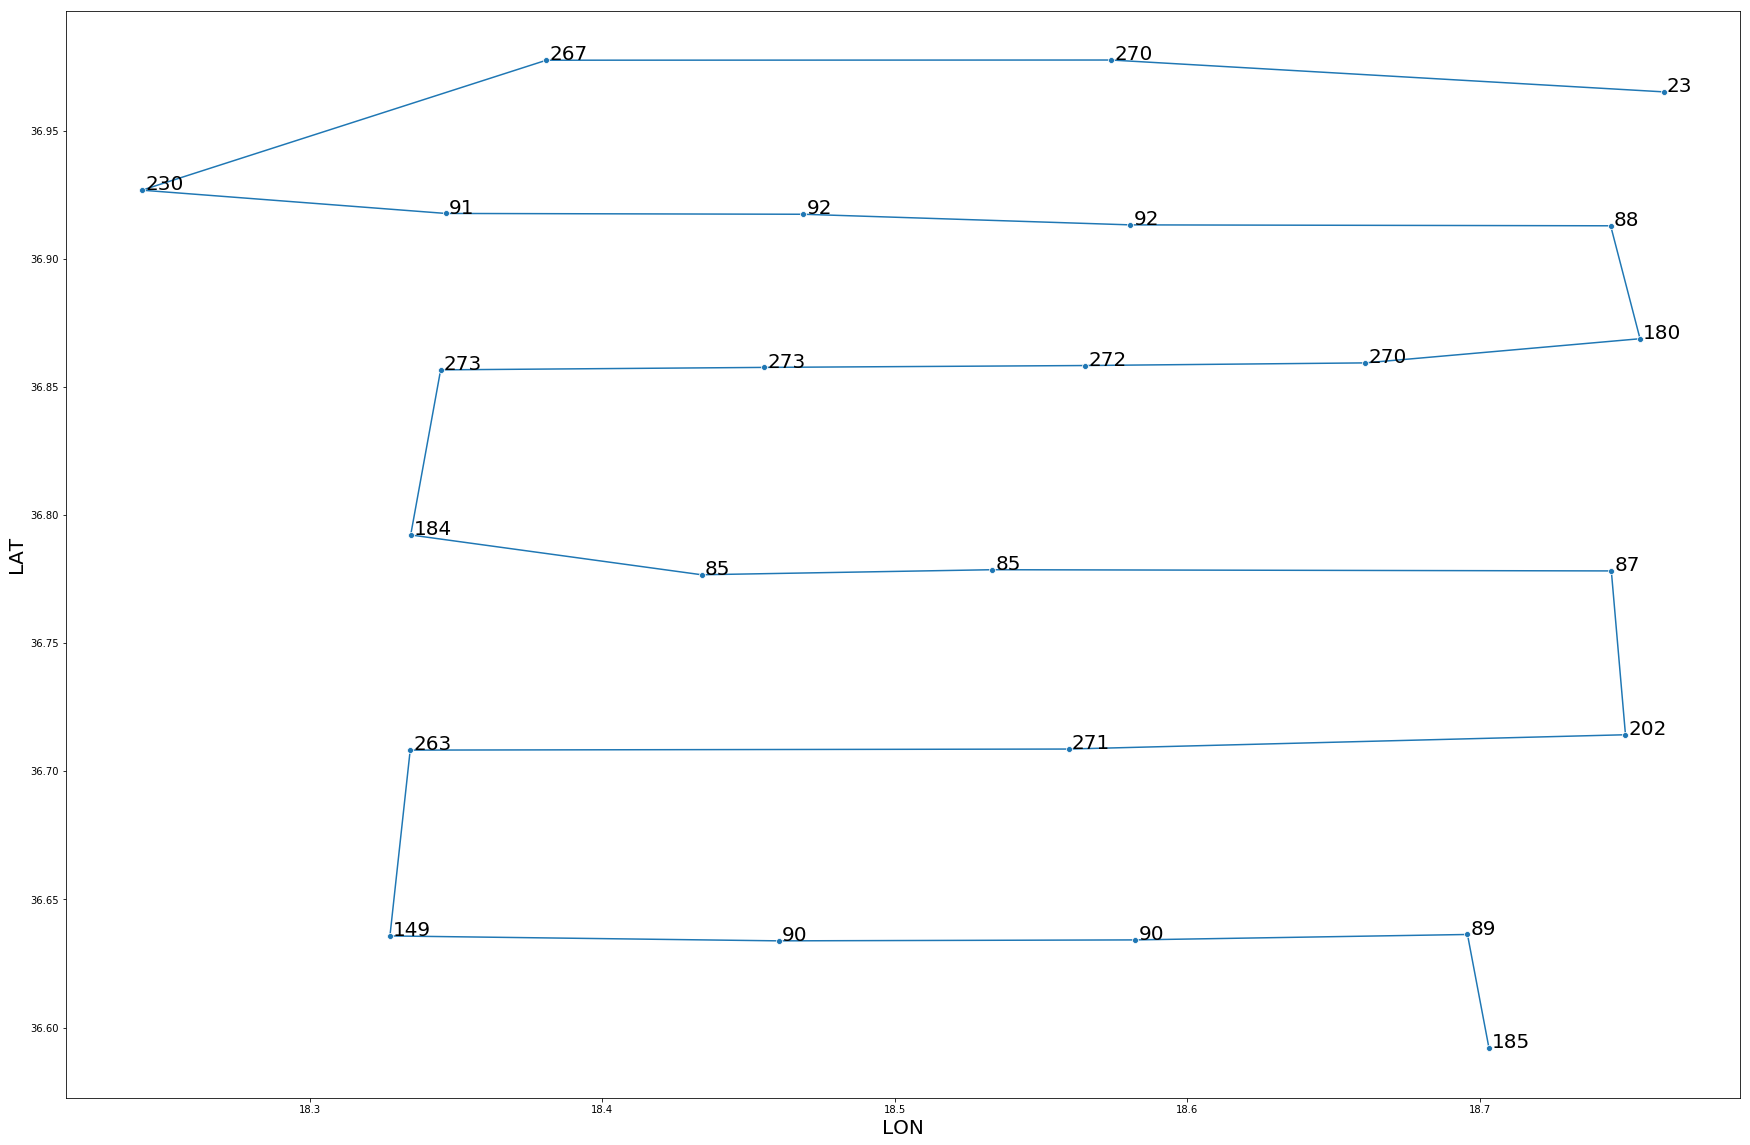

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 20)
ax.set_ylabel('Latitute', fontsize = 20.0) # Y label
ax.set_xlabel('Longitude ', fontsize = 20.0) # X label
data=real_data
#data=scalling_down_simple(data,train_test_options["split"])
data = scalling_down_windowed(real_data,train_test_options["split"])
print("size of data",len(data))
print(data)
# Plot using Seaborn
sns.lineplot(x='LON', y='LAT', data=data, ax=ax,sort=False,marker="o")
for j, point in data.iterrows():
    ax.text(point['LON']+0.0011, point['LAT'], str(point['HEADING']),fontsize=20)